## Bias a priori

*When implementing an AI system, fairness and biases must be an important component during conception, especially when dealing with sensitive information, and/or Personally Identifiable Information (PII), and/or Personal Health Information (PHI). Indeed, not only those information are bound to the law (e.g., GDPR in Europe), but they are also bound to a brand image challenge.*

Today's example aims at **assigning a risk with recruitment data**.

Before implementing any AI system to predict the likelihood of a candidate to be hired, **AI engineers AND business stakeholders** should:

- Sit and identify potential sources of biases
- Define one or several metrics that will quantify the bias of the AI system

## Dataset

StackOverflow's annual user-generated survey (over 70,000 responses from over 180 countries) of developers examines all aspects of the developer experience, from learning code to preferred technologies, version control and work experience.

From the survey results, we have built a dataset with the following columns:
- **Age**: age of the applicant, >35 years old or <35 years old *(categorical)*
- **EdLevel**: education level of the applicant (Undergraduate, Master, PhD...) *(categorical)*
- **Gender**: gender of the applicant, (Man, Woman, or NonBinary) *(categorical)*
- **MainBranch**: whether the applicant is a profesional developer *(categorical)*
- **YearsCode**: how long the applicant has been coding *(integer)*
- **YearsCodePro**: how long the applicant has been coding in a professional context, *(integer)*
- **PreviousSalary**: the applicant's previous job salary *(float)*
- **ComputerSkills**: number of computer skills known by the applicant *(integer)*
- **Employed**: target variable, whether the applicant has been hired *(categorical)*


## Exploratory Data Analysis


In [2]:
# Import libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Import data

In [3]:
# Load dataset.
survey_df = pd.read_csv("stackoverflow_full.csv", index_col=0)
survey_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73462 entries, 0 to 73461
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             73462 non-null  object 
 1   Accessibility   73462 non-null  object 
 2   EdLevel         73462 non-null  object 
 3   Employment      73462 non-null  int64  
 4   Gender          73462 non-null  object 
 5   MentalHealth    73462 non-null  object 
 6   MainBranch      73462 non-null  object 
 7   YearsCode       73462 non-null  int64  
 8   YearsCodePro    73462 non-null  int64  
 9   Country         73462 non-null  object 
 10  PreviousSalary  73462 non-null  float64
 11  HaveWorkedWith  73399 non-null  object 
 12  ComputerSkills  73462 non-null  int64  
 13  Employed        73462 non-null  int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 8.4+ MB


In [4]:
print(f"The dataset count {survey_df.shape[0]} observations "
      f"and {survey_df.shape[1]} columns")

The dataset count 73462 observations and 14 columns


In [5]:
# First observations.
survey_df.head()

,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed
0,<35,No,Master,1,Man,No,Dev,7,4,Sweden,51552.0,C++;Python;Git;PostgreSQL,4,0
1,<35,No,Undergraduate,1,Man,No,Dev,12,5,Spain,46482.0,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,12,1
2,<35,No,Master,1,Man,No,Dev,15,6,Germany,77290.0,C;C++;Java;Perl;Ruby;Git;Ruby on Rails,7,0
3,<35,No,Undergraduate,1,Man,No,Dev,9,6,Canada,46135.0,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...,13,0
4,>35,No,PhD,0,Man,No,NotDev,40,30,Singapore,160932.0,C++;Python,2,0


In [6]:
# Missing values.
survey_df.isna().sum()

Age                0
Accessibility      0
EdLevel            0
Employment         0
Gender             0
MentalHealth       0
MainBranch         0
YearsCode          0
YearsCodePro       0
Country            0
PreviousSalary     0
HaveWorkedWith    63
ComputerSkills     0
Employed           0
dtype: int64

### Descriptive statistics

#### univariate analysis

In [7]:
#
describe_num = survey_df.describe().T
describe_num.insert(describe_num.columns.get_loc("std") + 1, # insert after 'std'
                "relative_std", 
                describe_num["std"] / describe_num["mean"])
describe_num.T.round(2)

,Employment,YearsCode,YearsCodePro,PreviousSalary,ComputerSkills,Employed
count,73462.00,73462.00,73462.00,73462.00,73462.00,73462.00
mean,0.88,14.22,9.10,67750.26,13.43,0.54
std,0.32,9.41,7.96,49488.14,7.06,0.50
relative_std,0.36,0.66,0.87,0.73,0.53,0.93
min,0.00,0.00,0.00,1.00,0.00,0.00
25%,1.00,7.00,3.00,28839.00,8.00,0.00
50%,1.00,12.00,7.00,57588.00,13.00,1.00
75%,1.00,20.00,12.00,95979.00,17.00,1.00
max,1.00,50.00,50.00,224000.00,107.00,1.00


* There is 54% of people employed in the sample. THe sample is well balanced for the target variable ("Employed").
* The relative coefficients of all the (numeric) variables are less than 1, what might suggested few outliers (need to be confirm with a kernel distribution plot). But there are still relatively higher than 50% of the mean, what still suggest an important dispersion of individuals. Besides, the sample has its highest variation in the number of years of professional code.
* The average individual has been coding for 9 years including 8 of professional code, master 7 computer skills, with an expected previous annual salary of 0.54 * 67,750 USD equivalent.

In [8]:
# Categorical variable description.
describe_cat = survey_df.describe(include="object").T
describe_cat["top_item_freq"] = np.ceil(100 * describe_cat["freq"] / describe_cat["count"]) # frequency of the most frequent item (%)
describe_cat.T.round(2)

,Age,Accessibility,EdLevel,Gender,MentalHealth,MainBranch,Country,HaveWorkedWith
count,73462,73462,73462,73462,73462,73462,73462,73399
unique,2,2,5,3,2,2,172,69980
top,<35,No,Undergraduate,Man,No,Dev,United States of America,Python
freq,47819,71355,37402,68573,56944,67396,14696,71
top_item_freq,66,98,51,94,78,92,21,1


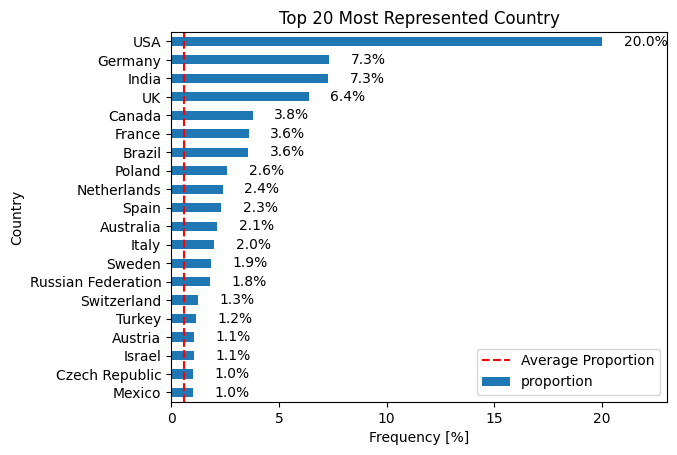

In [9]:
# Country distribution
survey_df["Country"] = (
    survey_df["Country"]
    .replace(r"United Kingdom of Great Britain and Northern Ireland", r"UK")
    .replace(r"United States of America", r"USA")
    )
country_series = survey_df["Country"].value_counts(normalize=True) * 100

# Plotting
def cat_top_plot(series, name="", hue=None, top=None, **kwargs):
    title = f"Top {top} Most Represented {name}" if top else f"{name} Distribution"
    ax = series.head(top).sort_values(ascending=True).plot(
        kind=kwargs["kind"],
        xlabel=kwargs["xlabel"],
        ylabel=kwargs["ylabel"],
        title=title,
        )

    # Adding Average Proportion Line
    avg_proportion = series.mean()
    ax.axvline(x=avg_proportion, color='red', linestyle='--', label='Average Proportion')

    # Adding labels to the bars
    for index, value in enumerate(series.head(top).sort_values(ascending=True)):
        ax.text(value + 1, index, f'{value:.1f}%', va='center', ha="left")

    ax.legend()
    plt.xlim((0, series.max() + kwargs["xlim_margin"]))
    plt.show()

cat_top_plot(country_series, name="Country", top=20, kind="barh", xlabel="Frequency [%]", ylabel="Country", xlim_margin=3)


# top = 20
# ax = country_series.head(top).sort_values(ascending=True).plot(
#     kind="barh",
#     xlabel="Frequency [%]",
#     ylabel="Country",
#     title=f"Top {top} Most Represented Country"
#     )

# # Adding Average Proportion Line
# avg_proportion = country_series.mean()
# ax.axvline(x=avg_proportion, color='red', linestyle='--', label='Average Proportion')

# Adding labels to the bars
# for index, value in enumerate(country_series.head(top).sort_values(ascending=True)):
#     ax.text(value + 1, index, f'{value:.1f}%', va='center', ha="left")

# ax.legend()
# plt.xlim(right=23)
# plt.show()


#TODO: Use a stacked cumulative plot to show that with the top 5 country represent already 45%
#TODO: Created a recoded country "CountryGrouped" variables into each of the Top 5, 
# continent (Other Europe, Africa, Other America, Other Asia, Oceania)

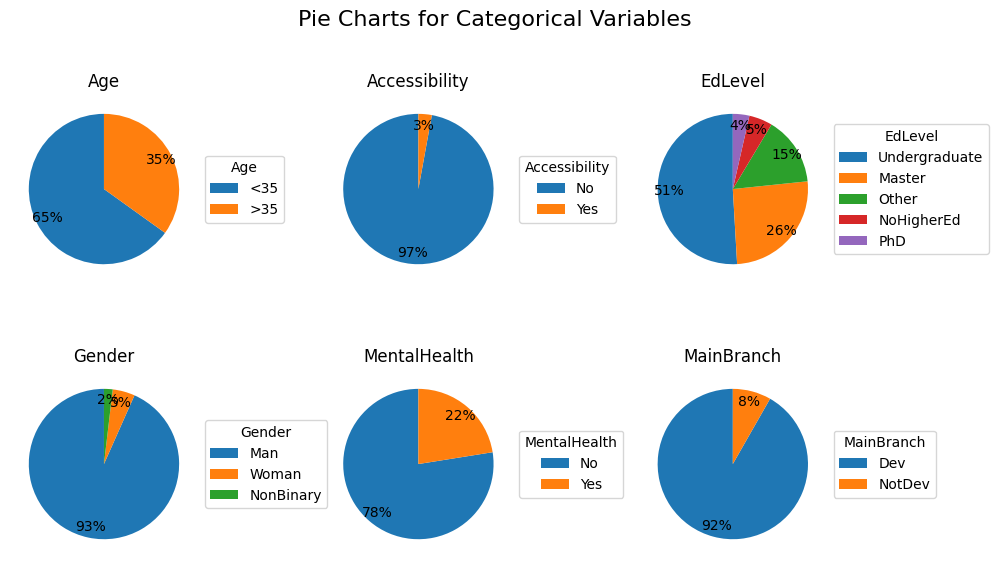

In [10]:
import matplotlib.pyplot as plt

# Extracting categorical variables
catcols_df = survey_df.select_dtypes(include=['object'])
catcols = catcols_df.columns
catcols_restricted_df = catcols_df.drop(columns=["Country", "HaveWorkedWith"])

# Calculating the number of rows and columns for subplots
n_variables = len(catcols_restricted_df.columns)
n_cols = 3
n_rows = int(np.ceil(n_variables / n_cols))

# Setting up subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, n_rows * 3))
fig.suptitle("Pie Charts for Categorical Variables", fontsize=16)

# Plotting pie charts for each categorical variable
for i, variable in enumerate(catcols_restricted_df.columns):
    row, col = divmod(i, n_cols)
    ax = axes[row, col]

    # Extracting value counts for the current variable
    value_counts = survey_df[variable].value_counts()

    # Plotting pie chart with improved label settings
    ax.pie(value_counts, labels=None, autopct='%1.0f%%', startangle=90, pctdistance=0.85, labeldistance=1.1)
    ax.set_title(variable)

    # Adding labels separately to avoid overlap
    ax.legend(value_counts.index, title=variable, loc="center left", bbox_to_anchor=(1, 0.5))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


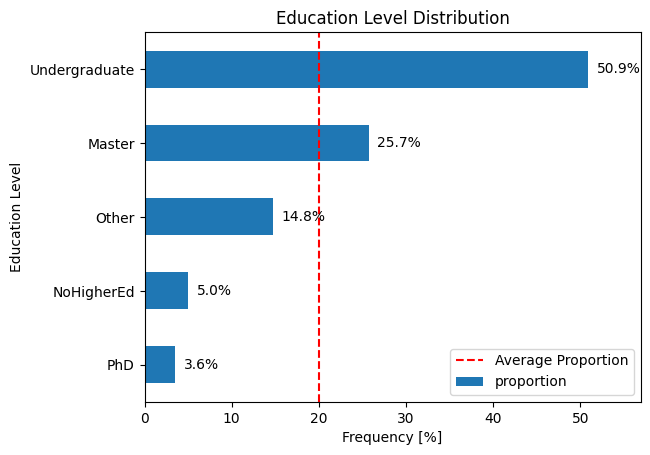

In [11]:
# Categorical variable
edlevel_series = survey_df["EdLevel"].value_counts(normalize=True) * 100
cat_top_plot(edlevel_series, name="Education Level", kind="barh", xlabel="Frequency [%]", ylabel="Education Level", xlim_margin=6)

#### bivariate analysis

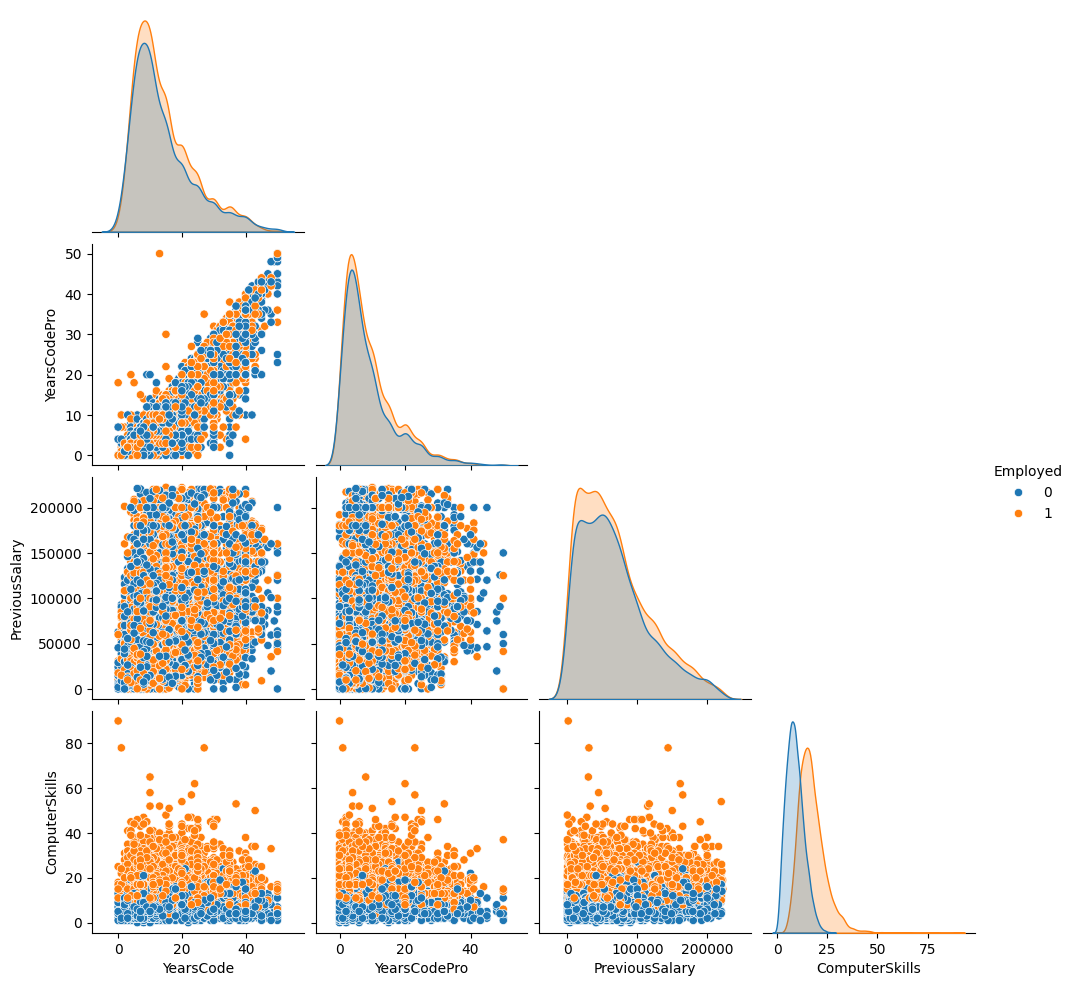

In [18]:
# Pairplot numerical variable on a fraction of the sample.
numcols = survey_df.select_dtypes("number").columns
sample_df = survey_df.sample(frac=0.15, replace=False, random_state=42)
sns.pairplot(sample_df[numcols].drop(columns="Employment"), hue="Employed", corner=True);

**Coding Years and Computer Skills Distribution**

On examining a subsample, the distribution of coding years and the computer skills index reveals a right tail, as confirmed by positive skewness (verified using `scipy.stats.skew`). Additionally, the distribution is leptokurtic, with kurtosis exceeding 3 (verified with `scipy.stats.kurtosis`) that is more concentration at the mean than a standard Gaussian. These findings suggest the presence of individuals with significantly higher numbers of coding years or computer skills than the majority of the population. Notably, the previous salary distribution appears to be a combination of two lightly right-tailed Gaussian distributions, each with closed means, indicating the existence of two distinct previous salary categories.

**Ventilation by Employment Status**

An exploration of ventilation concerning employment status indicates that individuals currently employed tend to have slightly more years of professional coding experience. Furthermore, employed individuals exhibit higher levels of computer skills, evident in a right-shifted distribution compared to the unemployed group.

**Global Variable Correlation**

In a comprehensive assessment, no clear correlation is discernible among variables, except for an evident positive correlation between the number of coding years and the number of professional coding years.

In [13]:
# Correlation matrix.
corr_matrix = survey_df.corr(numeric_only=True)
corr_matrix.style.background_gradient(cmap='coolwarm')

,Employment,YearsCode,YearsCodePro,PreviousSalary,ComputerSkills,Employed
Employment,1.000000,-0.080691,-0.092917,0.036980,-0.037904,-0.012142
YearsCode,-0.080691,1.000000,0.901073,0.390855,-0.020460,-0.003756
YearsCodePro,-0.092917,0.901073,1.000000,0.393615,-0.012838,0.002886
PreviousSalary,0.036980,0.390855,0.393615,1.000000,0.030362,0.000379
ComputerSkills,-0.037904,-0.020460,-0.012838,0.030362,1.000000,0.585545
Employed,-0.012142,-0.003756,0.002886,0.000379,0.585545,1.000000


**Correlation Matrix Analysis**

Upon reviewing the correlation matrix, our initial impressions are substantiated. Notably, the most prominent correlation observed is at a middle level, specifically 0.58, and it exists between employment status and computer skills.


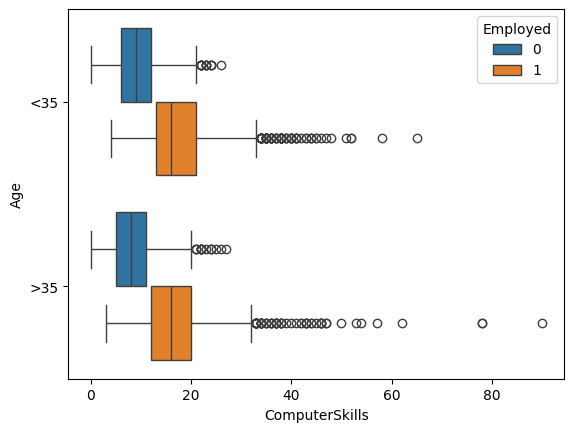

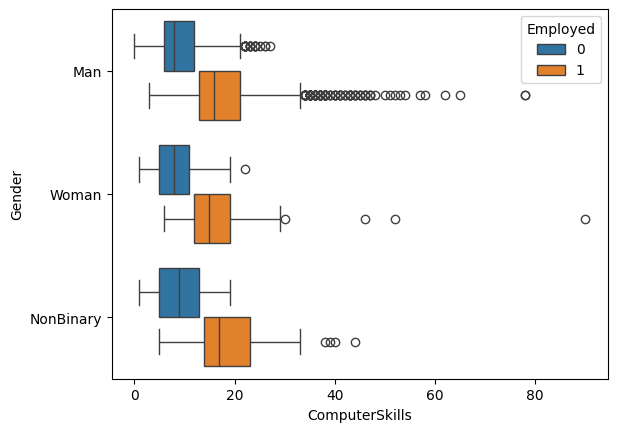

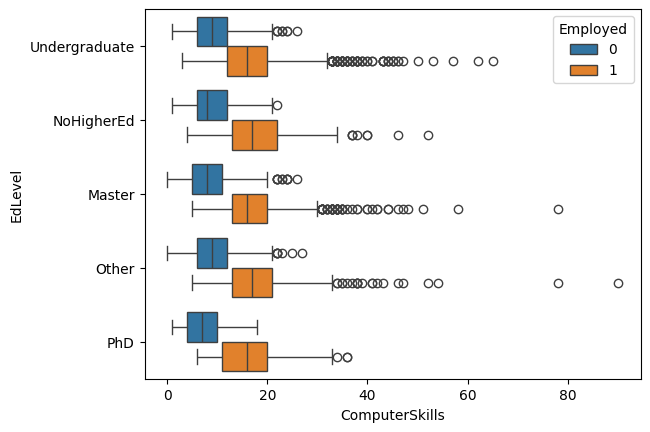

In [19]:
# Categorical variable
sns.boxplot(data=sample_df, y="Age", x="ComputerSkills", hue="Employed")
plt.show()

sns.boxplot(data=sample_df, y="Gender", x="ComputerSkills", hue="Employed")
plt.show()

sns.boxplot(data=sample_df, y="EdLevel", x="ComputerSkills", hue="Employed")
plt.show()


#### indentifying sensitive feature (qualitative analysis)

In [ ]:
survey_df.groupby(["Age", "Gender"])["Employed"].mean()
# survey_df.groupby("Age")["Employed"].mean()

Age  Gender   
<35  Man          0.551925
     NonBinary    0.560268
     Woman        0.462791
>35  Man          0.520347
     NonBinary    0.482105
     Woman        0.410448
Name: Employed, dtype: float64

In [ ]:
# Create a pivot table : "Age" vs "Gender"

## Check for differential employment
mean_pivot_table = survey_df.pivot_table(values='Employed', index='Age', columns='Gender', aggfunc='mean')
print(f"EMPLOYMENT RATE  \n{mean_pivot_table.round(4) * 100}")
print()

## Check for representativity
count_pivot_table = survey_df.pivot_table(values='Employed', index='Age', columns='Gender', aggfunc='count')
print(f"FREQUENCY [COUNT] \n{count_pivot_table}")

#TODO: REMINDER FOR MYSELF ! TRY FIRST A LOGISTIC REGRESSION TO LOOK FOR THE 
# EFFECTS OF SENTIVE FEATURES: GENDER (create `Woman` variable), AGE (create `Old` variable (>35))
# MENTAL HEALTH, ACCESSIBILITY WHILE CONTROLLING FOR THE OTHER OBSERVABLES.
# THE IDEA IS TO GRASP RAPIDLY THE CORRELATION CONDITIONNALY TO THE OTHER VARIABLE.
# THINK IN ADDING INTERACTION TERMS IN THE REGRESSION.  


EMPLOYMENT RATE  
Gender    Man  NonBinary  Woman
Age                            
<35     55.19      56.03  46.28
>35     52.03      48.21  41.04

FREQUENCY [COUNT] 
Gender    Man  NonBinary  Woman
Age                            
<35     44343        896   2580
>35     24230        475    938



```
# REMINDER: INITIAL EXPLORATION PLAN
* Consider starting with a logistic regression analysis to assess the impact of sensitive features, including creating a binary variable for `Woman` based on gender, and `Old` (>35) based on age. Also, examine the influence of mental health and accessibility while controlling for other observable variables. 
* This should allows to explore the correlation of each variable to conditionnally to the other.
* Experiment with introducing **interaction terms** in the regression model to check for finer potentially finer group of peoples.
```

Consider using statsmodel for log regression to avoid having to encode categorial variables
```
from statsmodels.formula.api import ols
tips = sns.load_dataset("tips")

model = ols('Employed ~ C(Age) + C(Gender) + C(MentalHealth) + C(Accessibility) + ComputerSkills + YearsCodePro', data=tips)
fitted_model = model.fit()
fitted_model.summary()

# Pay Atttention to how the variance are computed
```


In [ ]:
selected_features = [
    "Age", # sensitive
    "Accessibility", # sensitive
    "EdLevel", 
    "Gender", # sensitive +++
    "MentalHealth", # sensitive
    "MainBranch",
    "YearsCode",
    "YearsCodePro",
    "Country", # sensitive
    "PreviousSalary",
    "ComputerSkills",
]
target = "Employed"
all_columns = selected_features + target
categorical_features = survey_df.select_dtypes(object)

## Modeling

## Fairness performance

To facilitate the development of a responsible model, we use the dalex python package: https://dalex.drwhy.ai/


Quoting Dalex' tutorial:


> The idea is that ratios between scores of privileged and unprivileged metrics should be close to 1. The closer, the fairer. To relax this criterion a little bit, it can be written more thoughtfully:

> $$ \forall i \in \{a, b, ..., z\}, \quad \epsilon < \frac{metric_i}{metric_{privileged}} < \frac{1}{\epsilon}.$$

> Where the epsilon is a value between 0 and 1, it should be a minimum acceptable value of the ratio. On default, it is 0.8, which adheres to four-fifths rule (80% rule) often looked at in hiring, for example.
"

##### Metrics used

Description of the metrics used for the fairness performance evaluation of each strategys:



- **Equal opportunity ratio** computed from True positive rate (recall)

> This number describes the proportions of correctly classified positive instances.

> $TPR = \frac{TP}{P}$

- **Predictive parity ratio** computed from Positive predicted value (precision)

> This number describes the ratio of samples which were correctly classified as positive from all the positive predictions.

> $PPV = \frac{TP}{TP + FP}$

- **Accuracy equality ratio** computed from Accuracy

> This number is the ratio of the correctly classified instances (positive and negative) of all decisions.

> $ACC = \frac{TP + TN}{TP + FP + TN + FN}$

- **Predictive equality ratio** computed from False positive rate

> This number describes the share the proportion of actual negatives which was falsely classified as positive.

> $FPR = \frac{FP}{TP + TN}$

- **Statistical parity ratio** computed from Positive rate

> This number is the overall rate of positively classified instances, including both correct and incorrect decisions.

> $PR = \frac{TP + FP}{TP + FP + TN + FN}$

**Notes**:
1. Fairness metrics work the exact same way as performance metrics do. If one was to fit a model on the entire dataset and foster overfitting (namely, skipping a `train_test_split` operation), she would end up with a non biased model.
2. A lots of metrics can be computed. It is important to define early in the conception which are the critical metrics to monitor

The method `model_fairness` returns a fairness object from which fairness evaluations can be conducted. Notice that every metrics inherited from the confusion matrix are computed during the instantiation.

Two methods can then be performed:
- The `fairness_check` method, which returns a report on the fairness of the model. It requires an epsilon parameter that corresponds to the threshold ratio below which a given metric is considered to be unfair (default value is 0.8).
- The `plot` method, which allows to visualize the main fairness ratios between the protected subgroups and the privileged one.